<center><h1> Classify SMS messages as Spam or Legitimate</h1></center>

Link: https://www.kaggle.com/uciml/sms-spam-collection-dataset

**Context**
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

**Content**
The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

**Inspiration**
Use this dataset to build a prediction model that will accurately classify which texts are spam?

## Read the dataset

In [179]:
import os
import pandas as pd
import numpy as np

In [180]:
baseDir = "D:/Kaggle/SMS Classification/"

In [181]:
df = pd.read_csv(os.path.join(baseDir,'Dataset/spam.csv'), encoding='latin-1')

In [182]:
df.shape

(5572, 5)

In [183]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


We seem to have 3 unused columns. Let's drop them.

In [184]:
df.columns.values[2:]

array(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype=object)

In [185]:
df.drop(df.columns.values[2:], axis=1, inplace=True)

In [186]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [187]:
df.shape

(5572, 2)

## Vectorize the data

In [188]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

In [189]:
# Let's consider only the top 10000 words appearing in the messages
maxWords = 10000

We need to decide what's the maximum length of the messages that we shall consider.

In [190]:
# Get the size of each word
sizes = df['v2'].map(lambda x: len(x.split(" ")))

Plot them in a histogram.

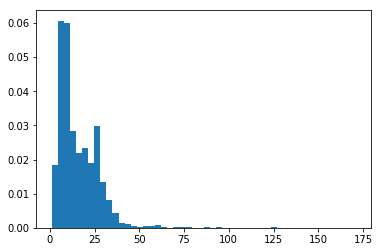

In [191]:
plt.hist(sizes, normed=True, bins=50);

We see that most values are below 100. So 100 seems to be a a reasonable length.

In [192]:
maxMessageSize = 100

In [193]:
labelText = df['v1'].tolist()
texts = df['v2'].tolist()

In [194]:
tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [195]:
data = pad_sequences(sequences, maxlen=maxMessageSize)

Encode labels: 0 indication Ham and 1 indication Spam.

In [196]:
labels = []
for i in labelText:
    if i == "ham":
        labels.append(0)
    elif i == "spam":
        labels.append(1)

In [197]:
labels = np.asarray(labels)

In [198]:
data.shape

(5572, 100)

In [199]:
labels.shape

(5572,)

**Shuffle the dataset**

In [200]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

## Split into training, testing and validation set

In [201]:
trainingSetSize = 3500
validationSetSize = 1000

In [202]:
trainingSet = data[:trainingSetSize]
trainingLabels = labels[:trainingSetSize]

validationSet = data[trainingSetSize: trainingSetSize + validationSetSize]
validationLabels = labels[trainingSetSize: trainingSetSize + validationSetSize]

testSet = data[trainingSetSize + validationSetSize:]
testLabels = labels[trainingSetSize + validationSetSize:]

## Build the model

**Architecture**
* A 100 dimensional Embedding layer
* 1 densely connected layer 32 hidden units, _reu_ activation
* 1 output layer, _sigmoid_ activation

In [203]:
from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics

In [204]:
embeddingDimension = 100

In [205]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDimension, input_length=maxMessageSize))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(1, activation=activations.sigmoid))

model.compile(optimizer=optimizers.Adam(lr=0.001), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

history = model.fit(trainingSet, trainingLabels, epochs=10, batch_size=64, validation_data=(validationSet, validationLabels))

Train on 3500 samples, validate on 1000 samples
Epoch 1/10
3500/3500 [==============================] - 1s 296us/step - loss: 0.2993 - binary_accuracy: 0.8500 - val_loss: 0.1556 - val_binary_accuracy: 0.9560
Epoch 2/10
3500/3500 [==============================] - 0s 141us/step - loss: 0.1385 - binary_accuracy: 0.9757 - val_loss: 0.1239 - val_binary_accuracy: 0.9840
Epoch 3/10
3500/3500 [==============================] - 0s 142us/step - loss: 0.1104 - binary_accuracy: 0.9900 - val_loss: 0.1169 - val_binary_accuracy: 0.9810
Epoch 4/10
3500/3500 [==============================] - 0s 137us/step - loss: 0.0980 - binary_accuracy: 0.9946 - val_loss: 0.1169 - val_binary_accuracy: 0.9790
Epoch 5/10
3500/3500 [==============================] - 0s 139us/step - loss: 0.0908 - binary_accuracy: 0.9971 - val_loss: 0.1217 - val_binary_accuracy: 0.9770
Epoch 6/10
3500/3500 [==============================] - 1s 143us/step - loss: 0.0861 - binary_accuracy: 0.9983 - val_loss: 0.1198 - val_binary_accuracy:

**Validation accuracy: 97.7%**

**Plot the loss and accuracy for the training and validation sets**

In [206]:
history.history.keys()

dict_keys(['val_binary_accuracy', 'val_loss', 'binary_accuracy', 'loss'])

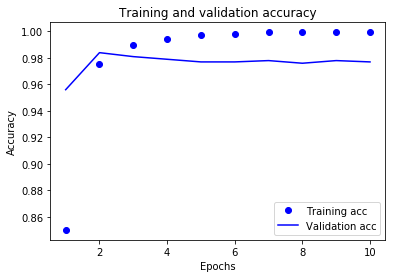

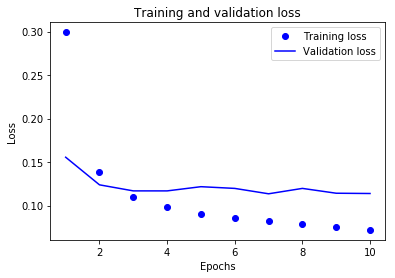

In [207]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Save the model

In [208]:
model.save("spamVsHam.h5")

## Evaluate on test set

In [209]:
testSet.shape

(1072, 100)

In [210]:
testLabels.shape

(1072,)

In [212]:
testLoss, testAccuracy = model.evaluate(testSet, testLabels)

1072/1072 [==============================] - 0s 92us/step


In [213]:
testAccuracy

0.9785447761194029